# Type B and Type C QPO toy dataset
**Instructions (by Abigail):** the data are in my gsoc18 repository. it's toy_TypeB_lightcurve.fits and toy_TypeC_lightcurve.fits. Note that I only used a subset of the total data I used for making the power spectra I already gave you, so plotting the average power spectrum of these data will look a little different. With this data you can make averaged cross spectra, take the amplitude, normalize it (leahy or frac, probably), log rebin (by 0.04 or so) and fit it! You'll find you'll need one or two lorentzians for the broadband noise components in addition to the QPO and the harmonic (and a  power law), even in the cross spectrum amplitudes. I think the slope of the power law should be around 0 for the cross spectra. See if you can take the average cross spectra amplitudes of one source in a few CoI and fit them simultaneously, even tying the Lorentzian center frequencies together (i.e., the QPO lorentzians have the same frequency in the 5 different avg cross spectra amplitudes you're fitting of the same source, and the same for the other lorentzian components).
This work that you're doing right now is important for both types of phase-resolved spectroscopy. For mine, it is necessary to fit the cross spectra to make the 'filter' (i.e. de-noising) to apply to the cross spectrum before taking the iFFT to get the energy-dependent cross-correlation function. For Adam Ingram's method, it is necessary to fit the power spectrum in each energy channel to determine the center and FWHM of the QPO and harmonic so that you can automatically re-bin the light curve, make the average cross spectrum, and get the complex and imaginary components (which he then uses in his equations to reconstruct the QPO waveform in each energy channel). You're doing a good job keeping up with this

## Loading dataset

In [1]:
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
type_b = "./toy_TypeB_lightcurve.fits"
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_b)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
lc_fits

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (46,) ct / s       Reference band light curves
  CI float64 (5, 46) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 46), ('NSECONDS', 64.0), ('INFILE', "['st.fits']"), ('OBJECT', 'GX_339-4')])


REF [46],"CI [5,46]"
ct / s,ct / s
float64,float64
256.0 .. 768.0,256.0 .. 0.0
256.0 .. 384.0,256.0 .. 0.0
512.0 .. 640.0,256.0 .. 0.0
640.0 .. 128.0,384.0 .. 0.0
1408.0 .. 384.0,384.0 .. 0.0
768.0 .. 768.0,768.0 .. 128.0
256.0 .. 512.0,512.0 .. 256.0
512.0 .. 128.0,512.0 .. 256.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
times = np.arange(0, n_seconds*n_seg, dt)
print(ref.shape, ci.shape, times.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape, times.shape)

(46, 8192) (46, 5, 8192) (376832,)
(376832,) (5, 376832) (376832,)


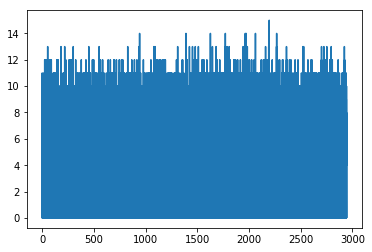

In [4]:
# taking all segments
counts = np.hstack(ref)
# print(times)
lc = Lightcurve(times, counts, dt=dt)
lc.plot()


57.24489923794965


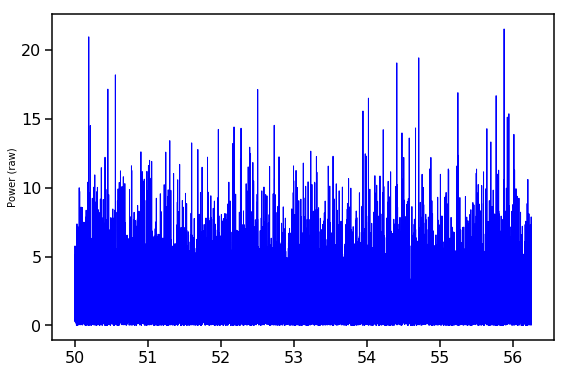

In [5]:
ps = Powerspectrum(lc, norm='leahy')

# print(len(ps.freq))
# print(ps.freq)
# print(ps.power)
# print(ps.df)
# print(ps.m)
# print(ps.n)
# print(ps.nphots1)

print(max(ps.power))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(ps.freq[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], ps.power[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], lw=1, color='blue')
ax1.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Power (raw)")
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [6]:
times = np.arange(0, n_seconds*n_seg, dt)
lc1 = Lightcurve(times, ref_counts, dt=dt)
lc2 = Lightcurve(times, ci_counts[0], dt=dt)

In [7]:
cs1 = Crossspectrum(lc1=lc1, lc2=lc2, norm='leahy', amplitude=True)
cs1 = cs1.rebin_log(0.04) # rebinning

/anaconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [8]:
avg_cs1 = AveragedCrossspectrum(lc1=lc1, lc2=lc2, segment_size=n_seg, norm='leahy')
avg_cs1 = avg_cs1.rebin_log(0.04) #rebinning

/anaconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<Figure size 432x288 with 0 Axes>

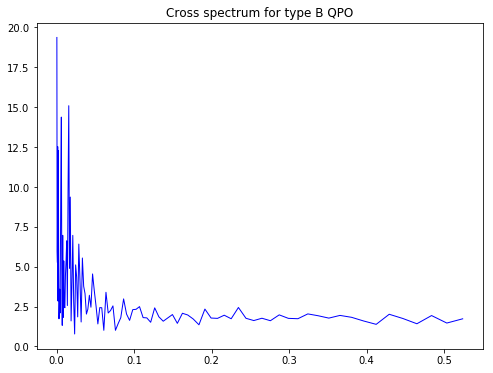

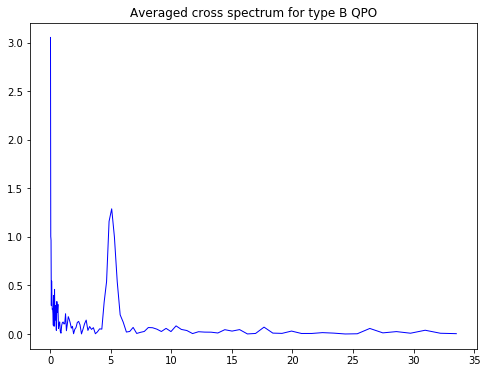

In [9]:
n = len(cs1.freq)
range_start, range_stop = int(0 * n / 64), int(30 * n / 64)

plt.tight_layout()
plt.subplots(0,0, figsize=(8,6))
plt.title("Cross spectrum for type B QPO")
plt.plot(cs1.freq[range_start:range_stop], np.abs(cs1.power)[range_start:range_stop], lw=1, color='blue')

plt.subplots(1,1, figsize=(8,6))
plt.title("Averaged cross spectrum for type B QPO")
plt.plot(avg_cs1.freq[range_start:range_stop], np.abs(avg_cs1.power)[range_start:range_stop], lw=1, color='blue')